# Visualizing Convolutional Filters with <font color='orange'>Pytorch<font>

<img src=https://miro.medium.com/max/3744/1*SGPGG7oeSvVlV5sOSQ2iZw.png width=70% img>

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import requests
from io import BytesIO

#### Plotting function for matrices

In [3]:
def plot_mat(mat, title=None, x_adj=0, y_adj=0, fontsize=20, vmin=-1, vmax=1.5):
    fig, ax = plt.subplots(figsize=(4, 4))
    
    if mat.ndim == 4 and type(mat) == torch.Tensor:
        mat = mat[0, 0, :, :].detach().numpy()
        
    ax.imshow(mat, cmap='viridis', vmin=vmin, vmax=vmax)

    for (x, y), z in np.ndenumerate(mat):
        ax.text(y + x_adj, x - y_adj, int(z), {'color':'white', 'fontsize':fontsize})
  
    lim = mat.shape[0] - .5
    
    for i in np.arange(.5, lim):
        plt.vlines(i, -.5, lim)
        plt.hlines(i, -.5, lim)

    plt.xticks([]); plt.yticks([])
    plt.title(title)
    plt.show()

#### The input

To understand convolutional filters in a simple manner, we will only use a tensor matrix full of ones as input.

In [4]:
ones = torch.ones(1, 1, 9, 9)

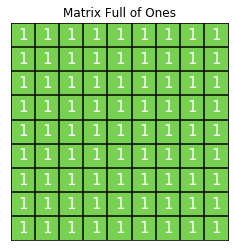

In [5]:
plot_mat(ones, title='Matrix Full of Ones', 
         fontsize=15, 
         x_adj=-.18, 
         y_adj=-.18)

#### The layer

Our layer is a simple convolutional layer, which output the same shape as the input. We will use __strides of 3__, meaning that the "jump" of the filter will be of 3. The __kernel size is _3x3___, so there are 9 values. We will set __bias to `None`__, so there will be no addition to all coefficients.

All this will be explained in further detail as we go. Summary:

$$
in\_channels = 1
\\ 
out\_channels = 1
\\
kernel\_size = (3, 3)
\\
stride = (3, 3)
$$

In [6]:
c = nn.Conv2d(in_channels=1, 
              out_channels=1, 
              kernel_size=3, 
              stride=3, 
              bias=None)

#### The filter

We will set up the filter manually, with `0` and `1` so it's easily understandable.

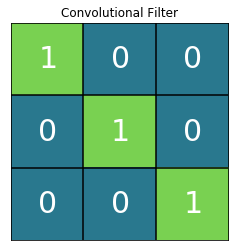

In [7]:
zeroone = torch.tensor(np.eye(3)).view(1, 1, 3, 3).type(torch.FloatTensor)
plot_mat(zeroone, x_adj=-.12, y_adj=-.12, fontsize=30, title='Convolutional Filter')

This filter will _slide_ above the input matrix (full of ones) and multiply every corresponding squares, and then sum them up. At every _slide_, the sum of multiplications (as one number) will be collated to form a new matrix.

#### Setting the filter

In [8]:
c.weight.data = zeroone

The new weights

In [9]:
print(zeroone)

tensor([[[[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]]]])


#### Passing the data through

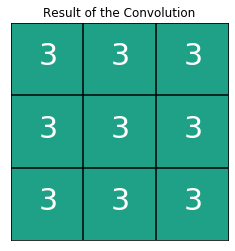

In [10]:
plot_mat(c(ones), vmax=6, x_adj=-.12, y_adj=-.08, fontsize=30, 
        title='Result of the Convolution')

The new matrix is all threes because there are 3 `1` in the filter, all of which are multiplied by `1` (remember the input matrix is only ones). So every filter/step/slide, there are 3 multiplications of `3*1`, that are summed. The rest of the filter are zeroes so they sum to nothing. 

#### Now with an `X` shaped filter

The holistic view is the following two matrices will be multiplied together, and summed up by every square of shape (3, 3)

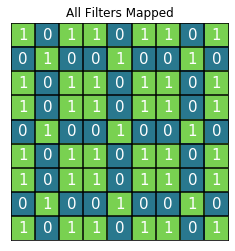

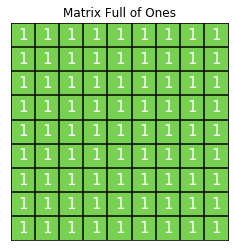

In [11]:
crossfilter = (np.eye(3) + np.rot90(np.eye(3)) >= 1)*1
plot_mat(np.tile(crossfilter, (3, 3)), title='All Filters Mapped', fontsize=15, y_adj=-.18, x_adj=-.18)
plot_mat(ones, title='Matrix Full of Ones', fontsize=15, y_adj=-.18, x_adj=-.18)

Can you guess the result of the next `3x3` matrix?

#### The new matrix

In [12]:
c.weight.data = torch.tensor([[crossfilter]]).type(torch.FloatTensor)

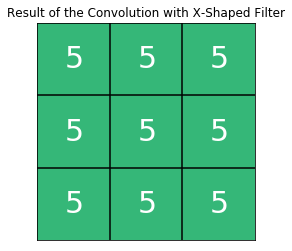

In [13]:
plot_mat(c(ones), vmax=8, x_adj=-.12, y_adj=-.12, fontsize=30, 
        title='Result of the Convolution with X-Shaped Filter')

#### Applying a convolutional filter to an image

In [14]:
vertical_filter, horizontal_filter = torch.zeros(2, 9, 9)
vertical_filter[:, 3:6] = 1
horizontal_filter[3:6, :] = 1

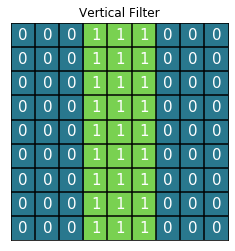

In [15]:
plot_mat(vertical_filter, x_adj=-.18, y_adj=-.18, fontsize=15, 
         title='Vertical Filter')

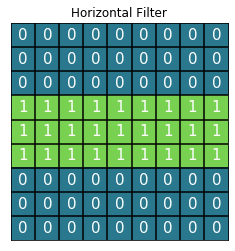

In [16]:
plot_mat(horizontal_filter, x_adj=-.18, y_adj=-.18, fontsize=15,
        title='Horizontal Filter')

#### Making vertical/horizontal convolutional layers

In [17]:
hz = nn.Conv2d(in_channels=3, 
               out_channels=3, 
               kernel_size=3, 
               stride=1, 
               bias=None)

In [18]:
hz.weight.data =  horizontal_filter.type('torch.FloatTensor').repeat(3, 3, 1, 1)

In [19]:
vt = nn.Conv2d(in_channels=3, 
               out_channels=3, 
               kernel_size=3, 
               stride=1, 
               bias=None)

In [20]:
vt.weight.data = vertical_filter.type('torch.FloatTensor').repeat(3, 3, 1, 1)

#### Applying convolutional layers to images

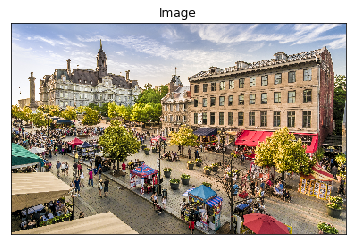

In [22]:
link = 'https://media.timeout.com/images/105465851/image.jpg'

r = requests.get(link, timeout=10)
im = Image.open(BytesIO(r.content))
im = im.resize((np.array(im).shape[1]//8, np.array(im).shape[0]//8))
plt.xticks([]), plt.yticks([])
plt.imshow(np.array(im))
plt.title('Image')

image = np.array(im)

In [23]:
rs7 = plt.imread('c:/users/nicolas/desktop/rs7.jfif')

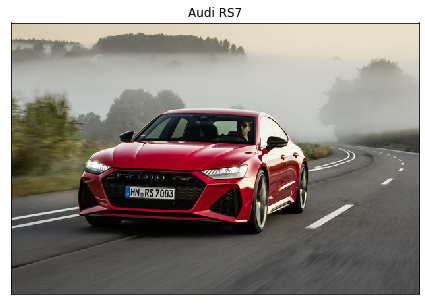

In [24]:
plt.figure(figsize=(8, 5))
plt.imshow(rs7)
plt.title('Audi RS7')
plt.xticks([]), plt.yticks([])
plt.show()

#### Applying the horizontal filter

In [25]:
hh = hz(torch.tensor(image[None, ...]).permute(0, 3, 1, 2).type('torch.FloatTensor'))
h = np.transpose(hh.detach().numpy(), (0, 2, 3, 1))[0, :, :, :]
h = h/np.max(h)

#### Applying the vertical filter

In [26]:
vv = vt(torch.tensor(image[None, ...]).permute(0, 3, 1, 2).type('torch.FloatTensor'))
v = np.transpose(vv.detach().numpy(), (0, 2, 3, 1))[0, :, :, :]
v = v/np.max(v)

#### Plotting both 

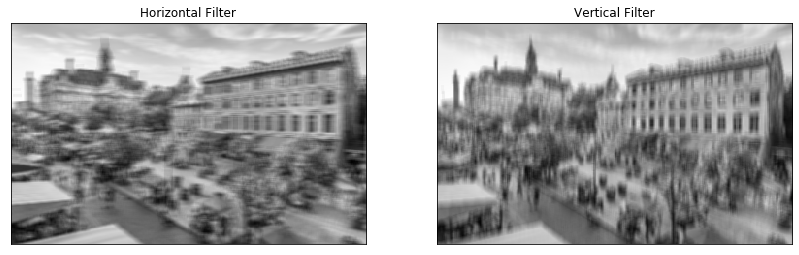

In [27]:
f, axarr = plt.subplots(1,2, figsize=(14, 14))
axarr[0].imshow(h)
axarr[0].set_yticks([]), axarr[0].set_xticks([])
axarr[0].title.set_text('Horizontal Filter')
axarr[1].imshow(v)
axarr[1].title.set_text('Vertical Filter')
axarr[1].set_yticks([]), axarr[1].set_xticks([])
plt.show()

#### Applying the filters several times

In [28]:
zz = hz(torch.tensor(image[None, ...]).permute(0, -1, 1, 2).type('torch.FloatTensor'))
for i in range(3):
    zzz = hz(zzz)
zzz = np.transpose(zzz.detach().numpy(), (0, 2, 3, 1))[0, :, :, :]
zzz = zzz/np.max(zzz)

In [29]:
yy = vt(torch.tensor(image[None, ...]).permute(0, -1, 1, 2).type('torch.FloatTensor'))
for i in range(3):
    yyy = vt(yyy)
yyy = np.transpose(yyy.detach().numpy(), (0, 2, 3, 1))[0, :, :, :]
yyy = yyy/np.max(yyy)

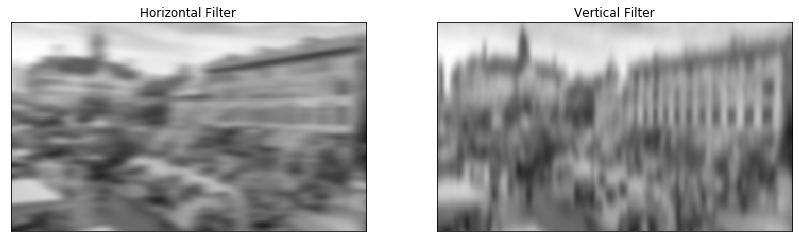

In [30]:
f, axarr = plt.subplots(1,2, figsize=(14, 14))
axarr[0].imshow(zzz)
axarr[0].set_yticks([]), axarr[0].set_xticks([])
axarr[0].title.set_text('Horizontal Filter')
axarr[1].imshow(yyy)
axarr[1].title.set_text('Vertical Filter')
axarr[1].set_yticks([]), axarr[1].set_xticks([])
plt.show()